In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from Bayesian import BayesianLinearRegression

from sklearn.model_selection import train_test_split


sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/BLRMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,FarmHeatStressMilkProduction
0,2022-01-01,a624fb9a,SE-064c0cec-1189,3095,02 SLB,7.0,191.0,2022-1,30.77,0.000000,...,35.914865,0.856748,0.000000,0,0,0,0,-3.025000,28.012944,0.009435
1,2022-01-02,a624fb9a,SE-064c0cec-1189,3096,02 SLB,7.0,192.0,2022-1,48.22,30.770000,...,35.799613,1.103224,0.243718,0,0,0,0,-0.279167,32.898193,0.009435
2,2022-01-03,a624fb9a,SE-064c0cec-1189,3097,02 SLB,7.0,193.0,2022-1,30.53,39.495000,...,35.684360,1.023044,-0.083744,0,0,0,0,2.033333,36.760487,0.009435
3,2022-01-04,a624fb9a,SE-064c0cec-1189,3098,02 SLB,7.0,194.0,2022-1,42.26,36.506667,...,35.569108,1.066796,0.040438,0,0,0,0,0.066667,31.939524,0.009435
4,2022-01-05,a624fb9a,SE-064c0cec-1189,3099,02 SLB,7.0,195.0,2022-1,38.49,37.945000,...,35.453856,1.073339,0.003074,0,0,0,0,-3.700000,26.498206,0.009435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483097,2023-06-03,f454e660,SE-fcdf259d-0044-0,4150,41 Fjällko,10.0,347.0,2023-3,12.67,14.652000,...,13.608593,1.030966,-0.045706,0,1,0,0,12.666667,53.132530,0.001001
483098,2023-06-04,f454e660,SE-fcdf259d-0044-0,4151,41 Fjällko,10.0,348.0,2023-3,22.31,14.030000,...,13.516773,1.108549,0.070579,0,1,0,0,13.079167,56.726870,0.001001
483099,2023-06-05,f454e660,SE-fcdf259d-0044-0,4152,41 Fjällko,10.0,349.0,2023-3,12.84,14.984000,...,13.424952,1.109278,-0.006853,0,1,0,0,14.237500,58.482418,0.001001
483100,2023-06-06,f454e660,SE-fcdf259d-0044-0,4153,41 Fjällko,10.0,350.0,2023-3,9.47,14.892000,...,13.333131,1.095617,-0.021300,0,1,0,0,15.345833,60.546358,0.001001


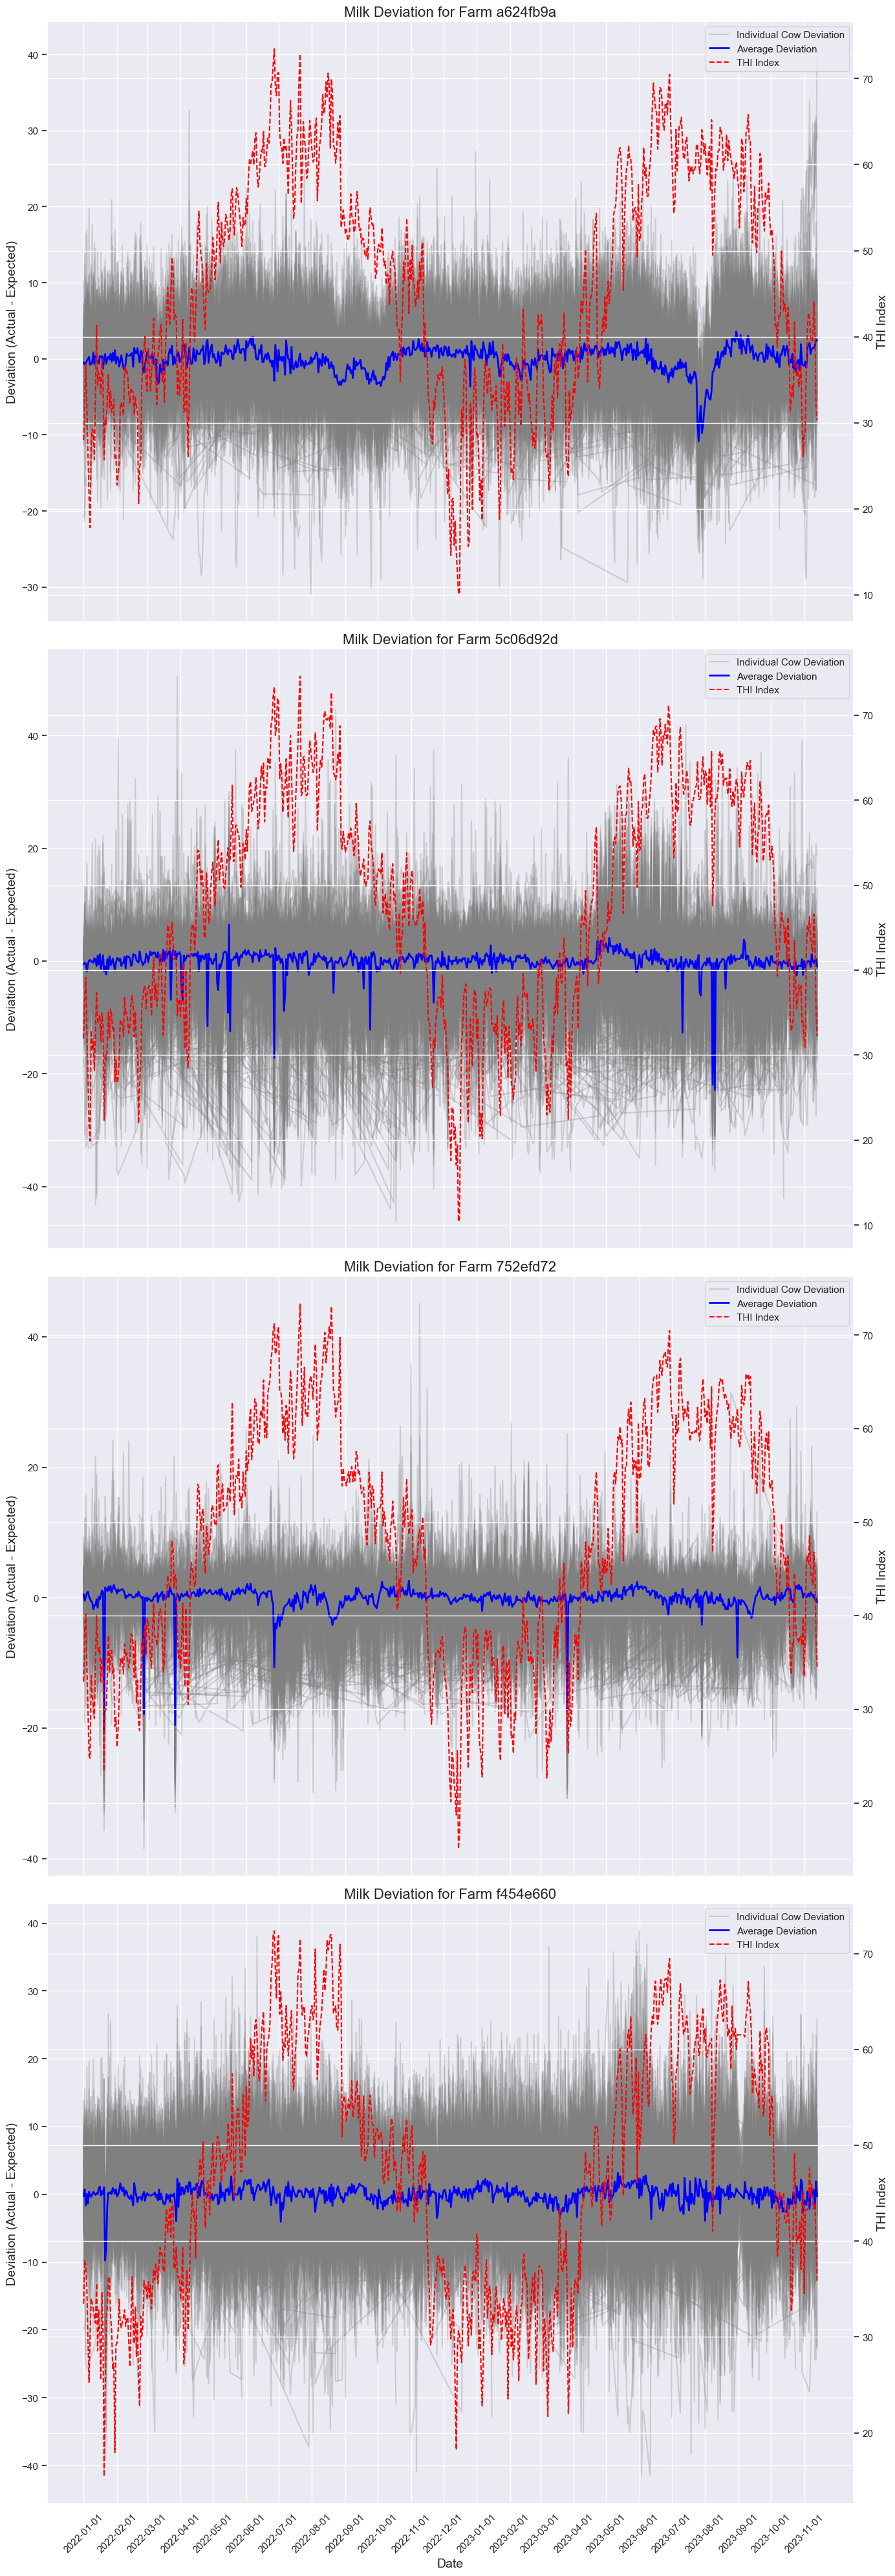

In [34]:
# List of farms
list_of_farms = milk_data['FarmName_Pseudo'].unique()

# Create a subplot for each farm
fig, axs = plt.subplots(len(list_of_farms), 1, figsize=(14, len(list_of_farms) * 10), sharex=True)

# Loop through each farm and plot in its subplot
for i, farm in enumerate(list_of_farms):
    ax = axs[i]
    
    # Select data for the current farm and create a copy
    selected_farm = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()
    
    # Calculate the deviation: ActualYield - ExpectedYield
    selected_farm['Deviation'] = selected_farm['DailyYield'] - selected_farm['ExpectedYield']
    
    # Plot individual cow deviations in a muted gray color
    for cow in selected_farm['SE_Number'].unique():
        cow_data = selected_farm[selected_farm['SE_Number'] == cow]
        ax.plot(cow_data['Date'], cow_data['Deviation'], color='gray', alpha=0.3, label='Individual Cow Deviation' if cow == selected_farm['SE_Number'].unique()[0] else "")
    
    # Plot the average deviation in a bright color (blue)
    avg_deviation = selected_farm.groupby('Date')['Deviation'].mean()
    ax.plot(avg_deviation.index, avg_deviation.values, color='blue', linewidth=2, label='Average Deviation')
    
    # Calculate the mean THI for each date (just one line)
    mean_thi = selected_farm.groupby('Date')['MeanTHI_adj'].mean()
    
    # Add secondary Y-axis for THI with a single clean line (red)
    ax2 = ax.twinx()
    ax2.plot(mean_thi.index, mean_thi.values, color='red', linestyle='--', label='THI Index')
    ax2.set_ylabel('THI Index', fontsize=14)
    
    # Set titles and labels
    ax.set_title(f'Milk Deviation for Farm {farm}', fontsize=16)
    ax.set_ylabel('Deviation (Actual - Expected)', fontsize=14)
    ax.grid(True)
    
    # Ensure X-axis ticks are shown for each subplot
    ax.set_xticks(pd.date_range(start=selected_farm['Date'].min(), end=selected_farm['Date'].max(), freq='MS'))
    ax.tick_params(axis='x', rotation=45)

    # Combine legends from both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Label for the X-axis
axs[-1].set_xlabel('Date', fontsize=14)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()